In [1]:
# %matplotlib notebook
%matplotlib inline
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kn
import matplotlib.tri as tri
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import logging
logging.getLogger("FFC").setLevel(logging.WARNING)
dolfin.parameters.reorder_dofs_serial = False

In [2]:
def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def mplot_cellfunction(cellfn):
    C = cellfn.array()
    tri = mesh2triang(cellfn.mesh())
    return plt.tripcolor(tri, facecolors=C)

def mplot_function(f):
    mesh = f.function_space().mesh()
    if (mesh.geometry().dim() != 2):
        raise AttributeError('Mesh must be 2D')
    # DG0 cellwise function
    if f.vector().size() == mesh.num_cells():
        C = f.vector().array()
        return plt.tripcolor(mesh2triang(mesh), C)
    # Scalar function, interpolated to vertices
    elif f.value_rank() == 0:
        C = f.compute_vertex_values(mesh)
        return plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    # Vector function, interpolated to vertices
    elif f.value_rank() == 1:
        w0 = f.compute_vertex_values(mesh)
        if (len(w0) != 2*mesh.num_vertices()):
            raise AttributeError('Vector field must be 2D')
        X = mesh.coordinates()[:, 0]
        Y = mesh.coordinates()[:, 1]
        U = w0[:mesh.num_vertices()]
        V = w0[mesh.num_vertices():]
        return plt.quiver(X,Y,U,V)

# Plot a generic dolfin object (if supported)
def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, Function):
        return mplot_function(obj)
    elif isinstance(obj, CellFunctionSizet):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionDouble):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionInt):
        return mplot_cellfunction(obj)
    elif isinstance(obj, Mesh):
        if (obj.geometry().dim() != 2):
            raise AttributeError('Mesh must be 2D')
        return plt.triplot(mesh2triang(obj), color='#808080')

    raise AttributeError('Failed to plot %s'%type(obj))
# end of commands for plotting

In [53]:
d = 2
thetaS = 0.2
#THIS SECTION IS FOR MAKING THE MESH

radiusOut = 10
radiusIn = 1

Out = Circle(Point(0,0),radiusOut)
In = Circle(Point(0,0),radiusIn)

dom = Out - In

mesh = generate_mesh(dom, 200)

mesh = refine(mesh)

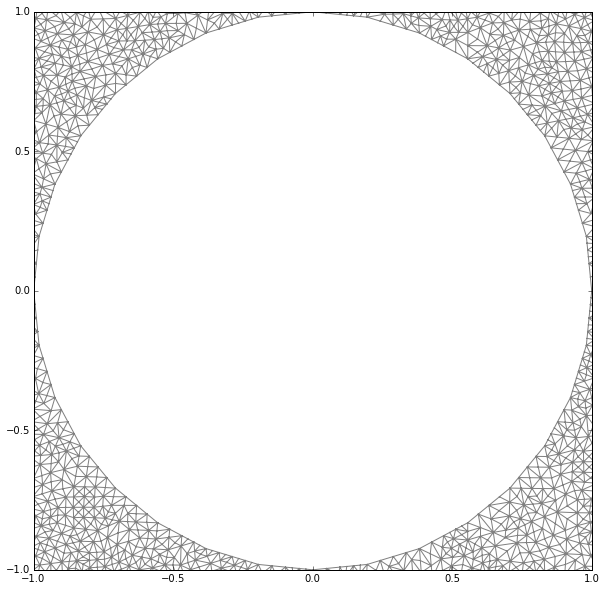

In [55]:
plt.figure(figsize=(10,10))
plot(mesh)
plt.xlim(-1,1),plt.ylim(-1,1);

In [56]:
#THIS SECTION IS FOR MARKING BOUNDARIES OF THE MESH
class outer_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-1
		r = sqrt(x[0]*x[0] + x[1]*x[1])
		return on_boundary and abs(r - radiusOut) < tol

class inner_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-1
		r = sqrt(x[0]*x[0] + x[1]*x[1])
		return on_boundary and abs(r - radiusIn) < tol

outerradius = outer_boundary()
innerradius = inner_boundary()

boundaries = FacetFunction("size_t", mesh)

boundaries.set_all(0)
innerradius.mark(boundaries,1)
outerradius.mark(boundaries,2)

In [57]:
#This section defines the finite element basis functions
V = FunctionSpace(mesh,'Lagrange',1)
nx = TrialFunction(V)
ny = TrialFunction(V)
v1 = TestFunction(V)
v2 = TestFunction(V)

In [58]:
#This section defines the boundary conditions
gx = Expression('-x[1]*sin(thetaS)/sqrt(x[0]*x[0] + x[1]*x[1])',thetaS = thetaS) 
gy = Expression('x[0]*sin(thetaS)/sqrt(x[0]*x[0] + x[1]*x[1])',thetaS = thetaS)

#For nx
bcs1 = [DirichletBC(V, 0, boundaries, 2), DirichletBC(V, gx, boundaries, 1)]
#for ny
bcs2 = [DirichletBC(V, 0, boundaries, 2), DirichletBC(V, gy, boundaries, 1)]

In [59]:
#This block solves the problem
f = Constant(0.0)
g = Constant(d**-2)

a1 = (inner(nabla_grad(nx), nabla_grad(v1)) + g*(inner(nx,v1)))*dx
a2 = (inner(nabla_grad(ny), nabla_grad(v2)) + g*(inner(ny,v2)))*dx
L1 = f*v1*dx
L2 = f*v2*dx
nx = Function(V)
ny = Function(V)
solve(a1 == L1, nx, bcs1)
solve(a2 == L2, ny, bcs2)

V_d = VectorFunctionSpace(mesh,'Lagrange',1)
w1 = TrialFunction(V_d)
w2 = TrialFunction(V_d)
q1 = TestFunction(V_d)
q2 = TestFunction(V_d)

a3 = inner(w1,q1)*dx
a4 = inner(w2,q2)*dx
L3 = inner(grad(nx),q1)*dx
L4 = inner(grad(ny),q2)*dx
grad_nx = Function(V_d)
grad_ny = Function(V_d)
solve(a3 == L3, grad_nx)
solve(a4 == L4, grad_ny)

dxnx, dynx = grad_nx.split(deepcopy=True)
dxny, dyny = grad_ny.split(deepcopy=True)

cell_markers = CellFunction("uint", mesh)
dx1 = Measure("dx", domain=mesh, subdomain_data=cell_markers)

splay = pow(dxnx+dyny,2)
twist = pow(dxny-dynx,2)
field = g*(pow(nx,2) + pow(ny,2))/2

fel = splay + twist + field

f1 = project(fel,V)

Esplay = assemble(splay*dx1)
Etwist = assemble(twist*dx1)
Efield = assemble(field*dx1)

Etot = Esplay + Etwist + Efield

In [60]:
# splay = pow(dxnx+dyny,2)
# twist = pow(dxny-dynx,2)
# field = g*(pow(nx,2) + pow(ny,2))/2

# f1 = splay + twist + field

# F1 = project(f1,V)

# Esplay = assemble(splay*dx1)
# Etwist = assemble(twist*dx1)
# Efield = assemble(field*dx1)

# Etot = Esplay + Etwist + Efield

In [61]:
print('Splay Energy %f' % Esplay)
print('Twist Energy %f' % Etwist)
print('E-field Energy %f' % Efield)
print('Total Energy %f' % Etot)

Splay Energy 0.000025
Twist Energy 0.021279
E-field Energy 0.023817
Total Energy 0.045121


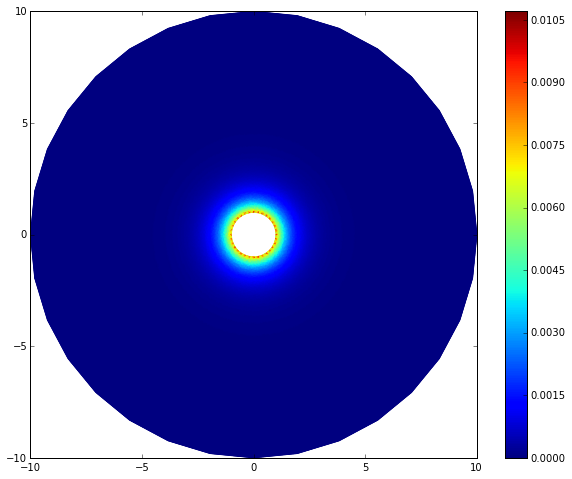

In [62]:
plt.figure(figsize=(10,10))
plot(f1)
plt.colorbar(shrink=0.8);

In [30]:
xx,yy,ff = [],[],[]
np.array(xx)
np.array(yy)
np.array(ff)

for x in np.linspace(-6,6,100):
    for y in np.linspace(-6,6,100):
        r = np.sqrt(x**2+y**2)
        #print(x,y,r)
        if (r >= 1) and (r < 10):
            xx.append(x)
            yy.append(y)
            ff.append(f1(x,y))
        elif r <= 1:   # if inside inner boundary, set to V_inner
            xx.append(x)
            yy.append(y)
            ff.append(np.NAN)
            #print('out')
        elif r >= 10: # if outside outer boundary, set to V_outer
            xx.append(x)
            yy.append(y)
            ff.append(0)
            #print('out')
#         else:
#             print('in',u(x,y))
print(len(xx),len(yy),len(ff))

(10000, 10000, 10000)


/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:584: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


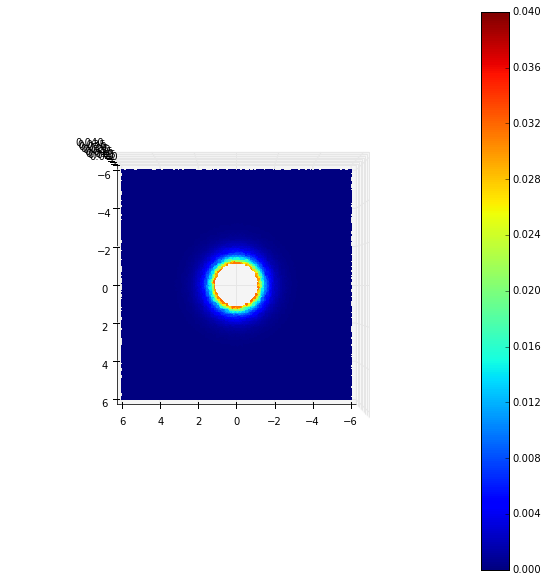

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(xx, yy, ff, cmap=cm.jet, shade=False,vmin=0,vmax=np.round(max(ff),2),linewidth=0,antialiased=False)
ax.view_init(90,90)
# surf.set_edgecolor('k')
ax.set_aspect('equal')
plt.colorbar(surf);